In [6]:
from datasets import load_dataset
pubmedqa = load_dataset("pubmed_qa", "pqa_unlabeled")
pqa_u = pubmedqa["train"]

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

# Converting to DataFrame
data_list = []
for item in pqa_u:
    data_list.append(item)

df = pd.DataFrame(data_list)

[nltk_data] Downloading package punkt to /Users/casey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/casey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Display the first few rows of the DataFrame
print(df.head())

      pubid                                           question  \
0  14499029  Is naturopathy as effective as conventional th...   
1  14499049  Can randomised trials rely on existing electro...   
2  14499672  Is laparoscopic radical prostatectomy better t...   
3  14499773  Does bacterial gastroenteritis predispose peop...   
4  14499777  Is early colonoscopy after admission for acute...   

                                             context  \
0  {'contexts': ['Although the use of alternative...   
1  {'contexts': ['To estimate the feasibility, ut...   
2  {'contexts': ['To compare morbidity in two gro...   
3  {'contexts': ['Irritable bowel syndrome (IBS) ...   
4  {'contexts': ['Urgent colonoscopy has been pro...   

                                         long_answer  
0  Naturopathy appears to be an effective alterna...  
1  Routine data have the potential to support hea...  
2  The results of our non-randomized study show t...  
3  Symptoms consistent with IBS and functional

In [13]:
# Extract year from pubdate
def extract_year(pubdate):
    if isinstance(pubdate, str):
        match = re.search(r'\d{4}', pubdate)
        if match:
            return int(match.group(0))
    return None

In [14]:
# Calculate text lengths
def calculate_text_length(text):
    if isinstance(text, str):
        return len(text.split())
    return 0

## 1. Dataset Overview and Context

In [19]:
# Extract year from pubid and add it as a new column
df['year'] = df['pubid'].apply(lambda x: extract_year(str(x)))

# Calculate context length and question length
df['context_length'] = df['context'].apply(calculate_text_length)
df['question_length'] = df['question'].apply(calculate_text_length)

# Statistics
print(f"Total number of questions: {len(df)}")
print(f"Year range: {df['year'].min()} to {df['year'].max()}")
print(f"Average context length: {df['context_length'].mean():.2f} words")
print(f"Average question length: {df['question_length'].mean():.2f} words")

# Sample
print("\nSample entry:")
sample = df.sample(1).iloc[0]
print(f"PMID: {sample['pubid']}")
print(f"Question: {sample['question']}")
# Extract the first 300 characters from the 'contexts' key in the 'context' dictionary
if isinstance(sample['context'], dict) and 'contexts' in sample['context']:
	context_preview = str(sample['context']['contexts'])[:300]
else:
	context_preview = "No valid context available"
print(f"Context: {context_preview}...")

# Data completeness
missing_values = df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

Total number of questions: 61249
Year range: 1002 to 9989
Average context length: 0.00 words
Average question length: 13.35 words

Sample entry:
PMID: 27256176
Question: Is [F-18]-fluorodeoxyglucose FDG-PET/CT better than ct alone for the preoperative lymph node staging of muscle invasive bladder cancer?
Context: ['To evaluate whether the use of [F-18]-FDG-PET/CT can accurately predict pelvic lymph node metastasis in patients with muscle invasive TCC of the bladder undergoing radical cystectomy.', 'Fifteen patients with muscle invasive bladder cancer had undergone FDG-PET/CT scan from the skull base to the m...

Missing values per column:
pubid              0
question           0
context            0
long_answer        0
year               0
context_length     0
question_length    0
dtype: int64


In [21]:
print("\nDataset schema:")
for col in df.columns:
    print(f"- {col}: {df[col].dtype}")
    if df[col].dtype == 'object' and isinstance(df[col].iloc[0], str):
        print(f"  Sample: {df[col].iloc[0][:100]}...")
    else:
        print(f"  Sample: {df[col].iloc[0]}")


Dataset schema:
- pubid: int64
  Sample: 14499029
- question: object
  Sample: Is naturopathy as effective as conventional therapy for treatment of menopausal symptoms?...
- context: object
  Sample: {'contexts': ['Although the use of alternative medicine in the United States is increasing, no published studies have documented the effectiveness of naturopathy for treatment of menopausal symptoms compared to women receiving conventional therapy in the clinical setting.', 'To compare naturopathic therapy with conventional medical therapy for treatment of selected menopausal symptoms.', 'A retrospective cohort study, using abstracted data from medical charts.', 'One natural medicine and six conventional medical clinics at Community Health Centers of King County, Washington, from November 1, 1996, through July 31, 1998.', 'Women aged 40 years of age or more with a diagnosis of menopausal symptoms documented by a naturopathic or conventional physician.', 'Improvement in selected menopausal

## 2. Data Distribution Analysis

/var/folders/4g/7cwxt52n09sb7vzyh6tzj3w00000gn/T/ipykernel_35206/1390547945.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=['Question Length', 'Context Length'])


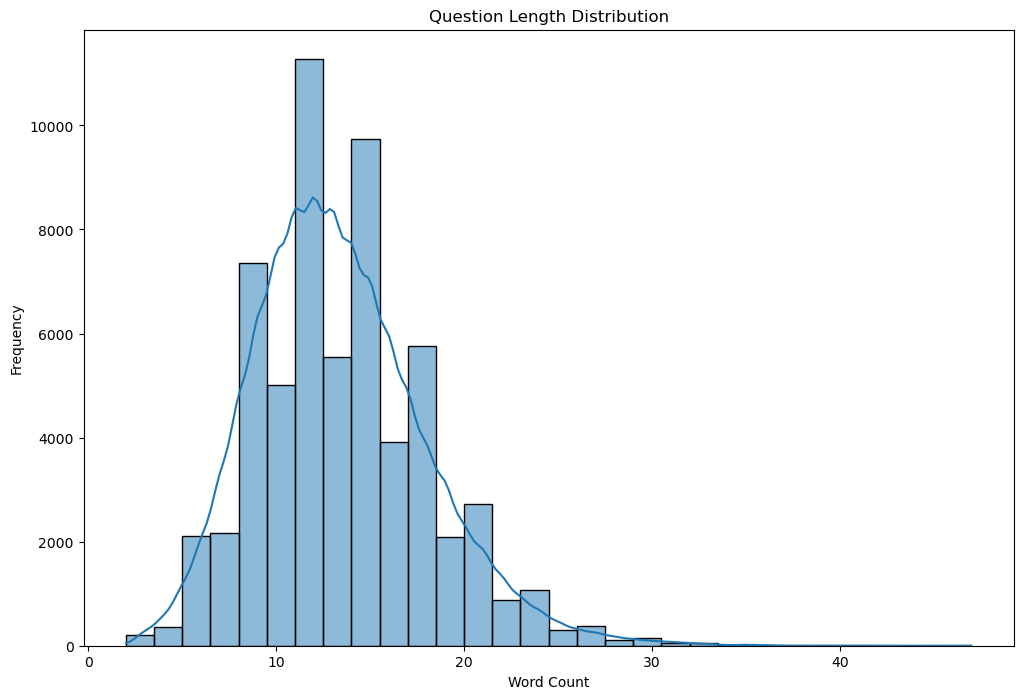

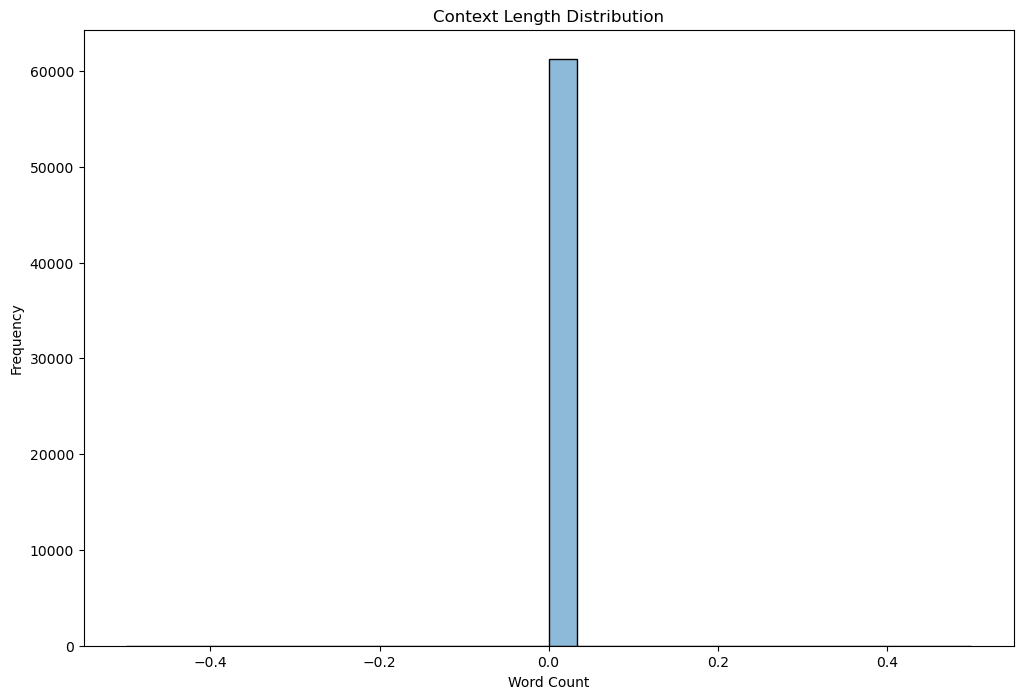

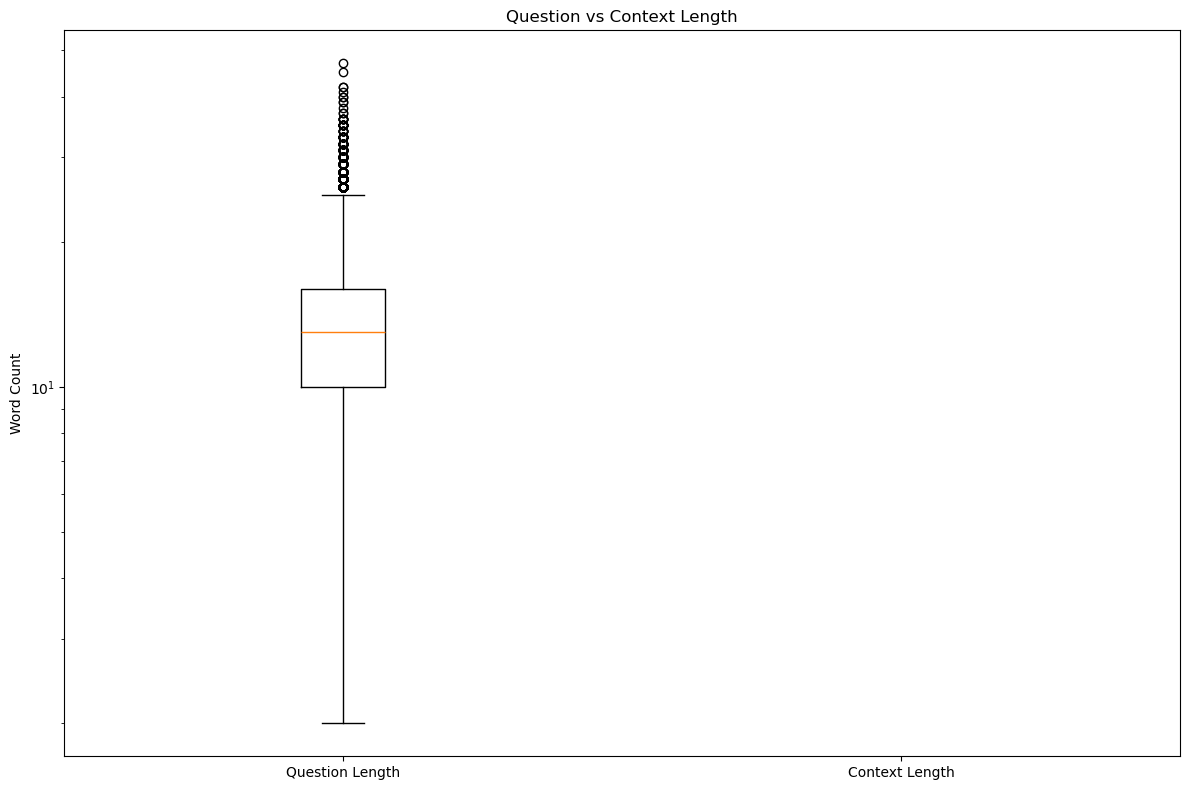

Length Statistics:
       question_length  context_length
count     61249.000000         61249.0
mean         13.345067             0.0
std           4.567044             0.0
min           2.000000             0.0
25%          10.000000             0.0
50%          13.000000             0.0
75%          16.000000             0.0
max          47.000000             0.0

Question length outliers: 783 (1.28%)
Context length outliers: 0 (0.00%)


In [25]:
# Question length distribution
plt.figure(figsize=(12, 8))
sns.histplot(df['question_length'], bins=30, kde=True)
plt.title('Question Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Context length distribution
plt.figure(figsize=(12, 8))
sns.histplot(df['context_length'], bins=30, kde=True)
plt.title('Context Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Box plots
plt.figure(figsize=(12, 8))
boxplot_data = [df['question_length'], df['context_length']]
plt.boxplot(boxplot_data, labels=['Question Length', 'Context Length'])
plt.title('Question vs Context Length')
plt.ylabel('Word Count')
plt.yscale('log')

plt.tight_layout()
plt.savefig('length_distributions.png')
plt.show()

# Statistics
length_stats = df[['question_length', 'context_length']].describe()
print("Length Statistics:")
print(length_stats)

# Identifying outliers
q_q1, q_q3 = np.percentile(df['question_length'], [25, 75])
q_iqr = q_q3 - q_q1
q_outliers = df[(df['question_length'] < q_q1 - 1.5 * q_iqr) | (df['question_length'] > q_q3 + 1.5 * q_iqr)]

c_q1, c_q3 = np.percentile(df['context_length'], [25, 75])
c_iqr = c_q3 - c_q1
c_outliers = df[(df['context_length'] < c_q1 - 1.5 * c_iqr) | (df['context_length'] > c_q3 + 1.5 * c_iqr)]

print(f"\nQuestion length outliers: {len(q_outliers)} ({len(q_outliers)/len(df)*100:.2f}%)")
print(f"Context length outliers: {len(c_outliers)} ({len(c_outliers)/len(df)*100:.2f}%)")